In [1]:
%pip install sqlalchemy pyodbc matplotlib seaborn plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Database connection configuration
# Replace with your actual credentials
server = 'upgrade-abnb-server.database.windows.net'
database = 'Upgrade_Abnb'
username = 'vmabnbserver'  # Replace with actual username
password = 'JWkWW8Bg%>jy,Xj!'  # Replace with actual password

# Function to test ODBC drivers and create connection
def create_db_connection():
    """Create database connection with fallback driver options"""
    drivers = [
        'ODBC Driver 18 for SQL Server',
        'ODBC Driver 17 for SQL Server',
        'ODBC Driver 13 for SQL Server',
        'SQL Server Native Client 11.0',
        'SQL Server'
    ]
    
    # Test available drivers
    available_drivers = [driver for driver in pyodbc.drivers() if any(d in driver for d in ['SQL Server', 'ODBC'])]
    print(f"Available ODBC drivers: {available_drivers}")
    
    for driver in drivers:
        if driver in available_drivers:
            try:
                connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&TrustServerCertificate=yes&Encrypt=yes'
                engine = create_engine(connection_string)
                # Test connection
                with engine.connect() as conn:
                    conn.execute(sqlalchemy.text("SELECT 1"))
                print(f"Successfully connected using driver: {driver}")
                return engine, connection_string
            except Exception as e:
                print(f"Failed with driver {driver}: {str(e)}")
                continue
    
    # If all drivers fail, try without encryption
    for driver in drivers:
        if driver in available_drivers:
            try:
                connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&TrustServerCertificate=yes'
                engine = create_engine(connection_string)
                # Test connection
                with engine.connect() as conn:
                    conn.execute(sqlalchemy.text("SELECT 1"))
                print(f"Successfully connected using driver (no encryption): {driver}")
                return engine, connection_string
            except Exception as e:
                print(f"Failed with driver {driver} (no encryption): {str(e)}")
                continue
    
    raise Exception("Could not establish database connection with any available driver")

# Create connection engine
engine, connection_string = create_db_connection()

# Function to execute queries and return DataFrames
def query_to_df(query, engine=engine):
    """Execute SQL query and return DataFrame"""
    return pd.read_sql(query, engine)

# Load main dataset
query = "SELECT * FROM [dbo].[listings_completo]"
df_listings = query_to_df(query)

# Configure matplotlib and seaborn for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display basic information
print("=== DATABASE CONNECTION ESTABLISHED ===")
print(f"Connected to: {database}")
print(f"DataFrame shape: {df_listings.shape}")
print(f"Columns: {list(df_listings.columns)}")
print("\n=== FIRST 5 ROWS ===")
print(df_listings.head())
print("\n=== DATA TYPES ===")
print(df_listings.dtypes)
print("\n=== MISSING VALUES ===")
print(df_listings.isnull().sum())

Available ODBC drivers: ['SQL Server']
Successfully connected using driver: SQL Server
=== DATABASE CONNECTION ESTABLISHED ===
Connected to: Upgrade_Abnb
DataFrame shape: (424210, 63)
Columns: ['listing_id', 'id_x', 'date', 'reviewer_id', 'reviewer_name', 'id_y', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d'

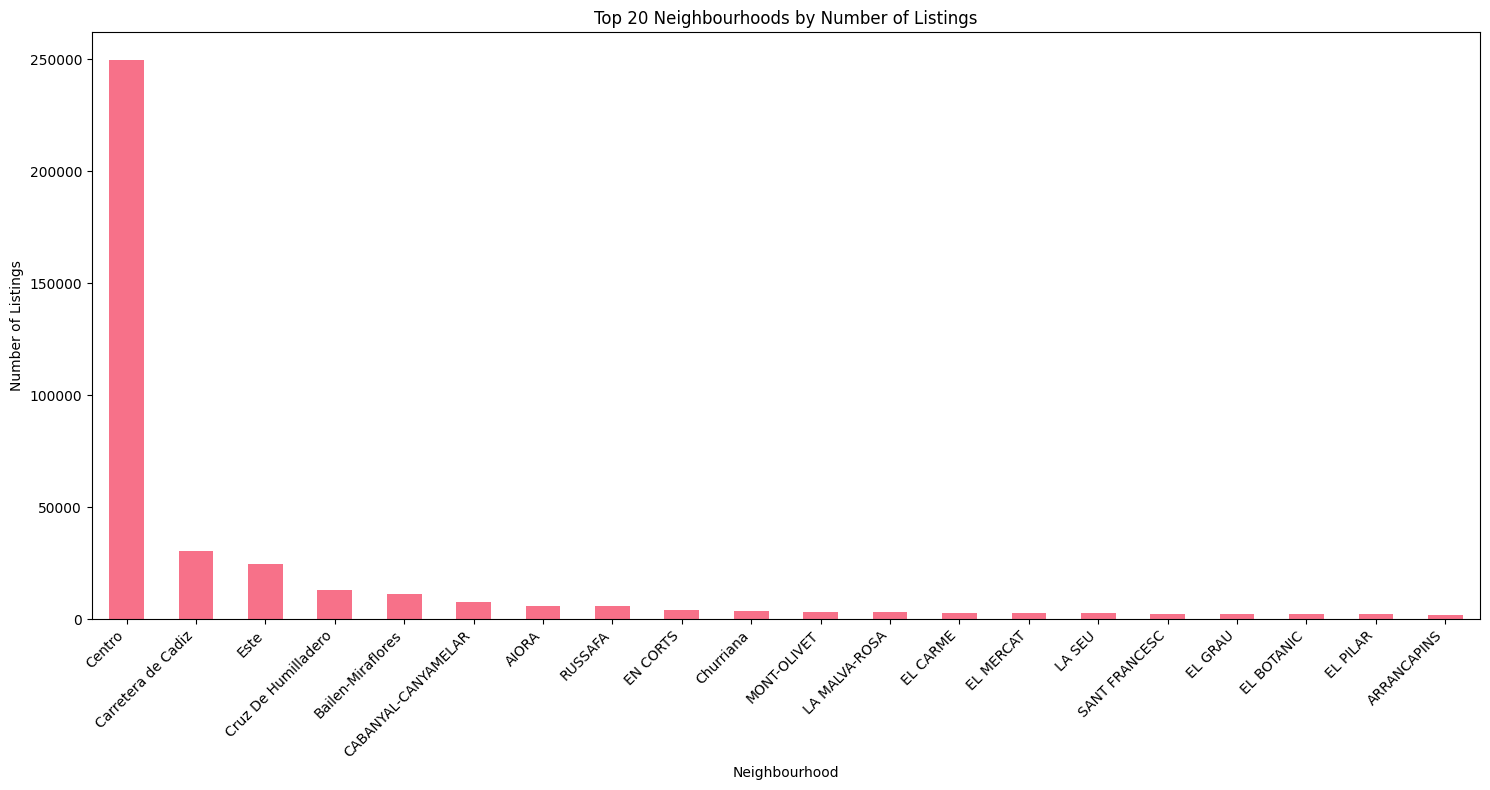

Top 10 Neighbourhoods by Listing Count:
neighbourhood_cleansed
Centro                 249588
Carretera de Cadiz      30492
Este                    24617
Cruz De Humilladero     13026
Bailen-Miraflores       11344
CABANYAL-CANYAMELAR      7606
AIORA                    6020
RUSSAFA                  5879
EN CORTS                 4212
Churriana                3641
Name: count, dtype: int64


In [3]:
# Count listings by neighbourhood
neighbourhood_counts = df_listings['neighbourhood_cleansed'].value_counts()

# Create a bar plot
plt.figure(figsize=(15, 8))
neighbourhood_counts.head(20).plot(kind='bar')
plt.title('Top 20 Neighbourhoods by Number of Listings')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the top 10 neighbourhoods with counts
print("Top 10 Neighbourhoods by Listing Count:")
print(neighbourhood_counts.head(10))